
# Assumptions in regression model

We will check in two examples how the asusmptions of the regression model can be checked and validated. We based the excellent transformation example from https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py




In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor    


/Users/axelsirota/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/axelsirota/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/axelsirota/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/axelsirota/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<h2> Lack of normality

A synthetic random regression problem is generated. The targets ``y`` are
modified by: (i) translating all targets such that all entries are
non-negative and (ii) applying an exponential function to obtain non-linear
targets which cannot be fitted using a simple linear model.

Therefore, a logarithmic (`np.log1p`) and an exponential function
(`np.expm1`) will be used to transform the targets before training a linear
regression model and using it for prediction.



In [2]:
X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.exp((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

The following illustrate the probability density functions of the target
before and after applying the logarithmic functions.



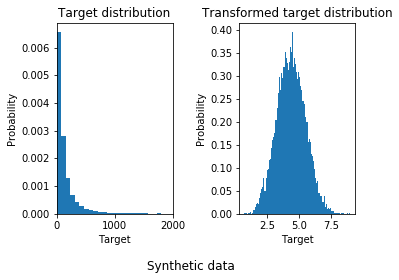

In [3]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **{'density': True})
ax0.set_xlim([0, 2000])
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **{'density': True})
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

At first, a linear model will be applied on the original targets. Due to the
non-linearity, the model trained will not be precise during the
prediction. Subsequently, a logarithmic function is used to linearize the
targets, allowing better prediction even with a similar linear model as
reported by the median absolute error (MAE).



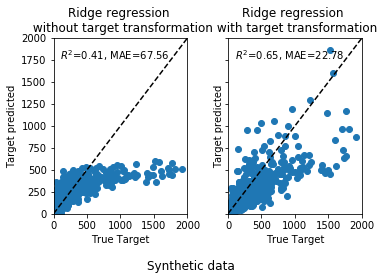

In [4]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot([0, 2000], [0, 2000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Linear regression \n without target transformation')
ax0.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 2000])
ax0.set_ylim([0, 2000])

regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 2000], [0, 2000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Linear regression \n with target transformation')
ax1.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 2000])

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

<h2> Collinearity and significance

In [5]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Tue, 27 Aug 2019   Prob (F-statistic):           3.83e-62
Time:                        00:00:23   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

In [6]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + str(X.iloc[:, variables].columns[maxloc]) +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [7]:
X = calculate_vif_(pd.DataFrame(X))

dropping '4' at index: 4
dropping '7' at index: 6
Remaining variables:
Int64Index([0, 1, 2, 3, 5, 6, 8, 9], dtype='int64')


In [8]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     57.12
Date:                Tue, 27 Aug 2019   Prob (F-statistic):           4.35e-63
Time:                        00:00:23   Log-Likelihood:                -2387.9
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     433   BIC:                             4831.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.581     58.937      0.0

/Users/axelsirota/repos/interpreting-data-with-advanced-models/pluralsight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
